In [9]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
from tqdm import tqdm
path = '../input/child-mind-institute-problematic-internet-use/'

train = pd.read_csv(path + 'train.csv', index_col = 'id')
print("The train data has the shape: ",train.shape)
test = pd.read_csv(path + 'test.csv', index_col = 'id')
print("The test data has the shape: ",test.shape)
print("")
print("Total number of missing training values: ", train.isna().sum().sum())
train_cat_columns = train.select_dtypes(exclude = 'number').columns

for season in train_cat_columns:
    train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
PCIAT_cols = [val for val in train.columns[train.columns.str.contains('PCIAT')]]
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train = train.drop(columns = PCIAT_cols)
train = train.dropna(subset='sii')

The train data has the shape:  (3960, 81)
The test data has the shape:  (20, 58)

Total number of missing training values:  131717


/tmp/ipykernel_30/2078737664.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


In total there are 3960 train data with 131717 missing values (nan)

We will split the train data into train_model and train_val. The following stratified split data will help split it.

the convert function should be able to convert PCIAT system (0-100) to sii 

quadratic kappa is the function used in the competition to evaluate randomness and accuracy. 

In [10]:
def stratified_split_data(data, ratio=0.7):
    train_model = []
    train_val = []

    # Loop over each unique category in 'sii'
    for sii_value in data['sii'].unique():
        subset = data[data['sii'] == sii_value]  # Filter by current sii value
        
        subset = subset.sample(frac=1)
        
        split_index = round(len(subset) * ratio)
        train_model.append(subset[:split_index])
        train_val.append(subset[split_index:])

        print(f"sii = {sii_value} | Train: {len(train_model[-1])} | Val: {len(train_val[-1])}")

    # Concatenate all sii-category splits
    train_model = pd.concat(train_model)
    train_val = pd.concat(train_val)

    return train_model, train_val

def convert(scores):
    scores = np.array(scores)*1.3
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

The following function will explore the correlation of nan in each individual features. 

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


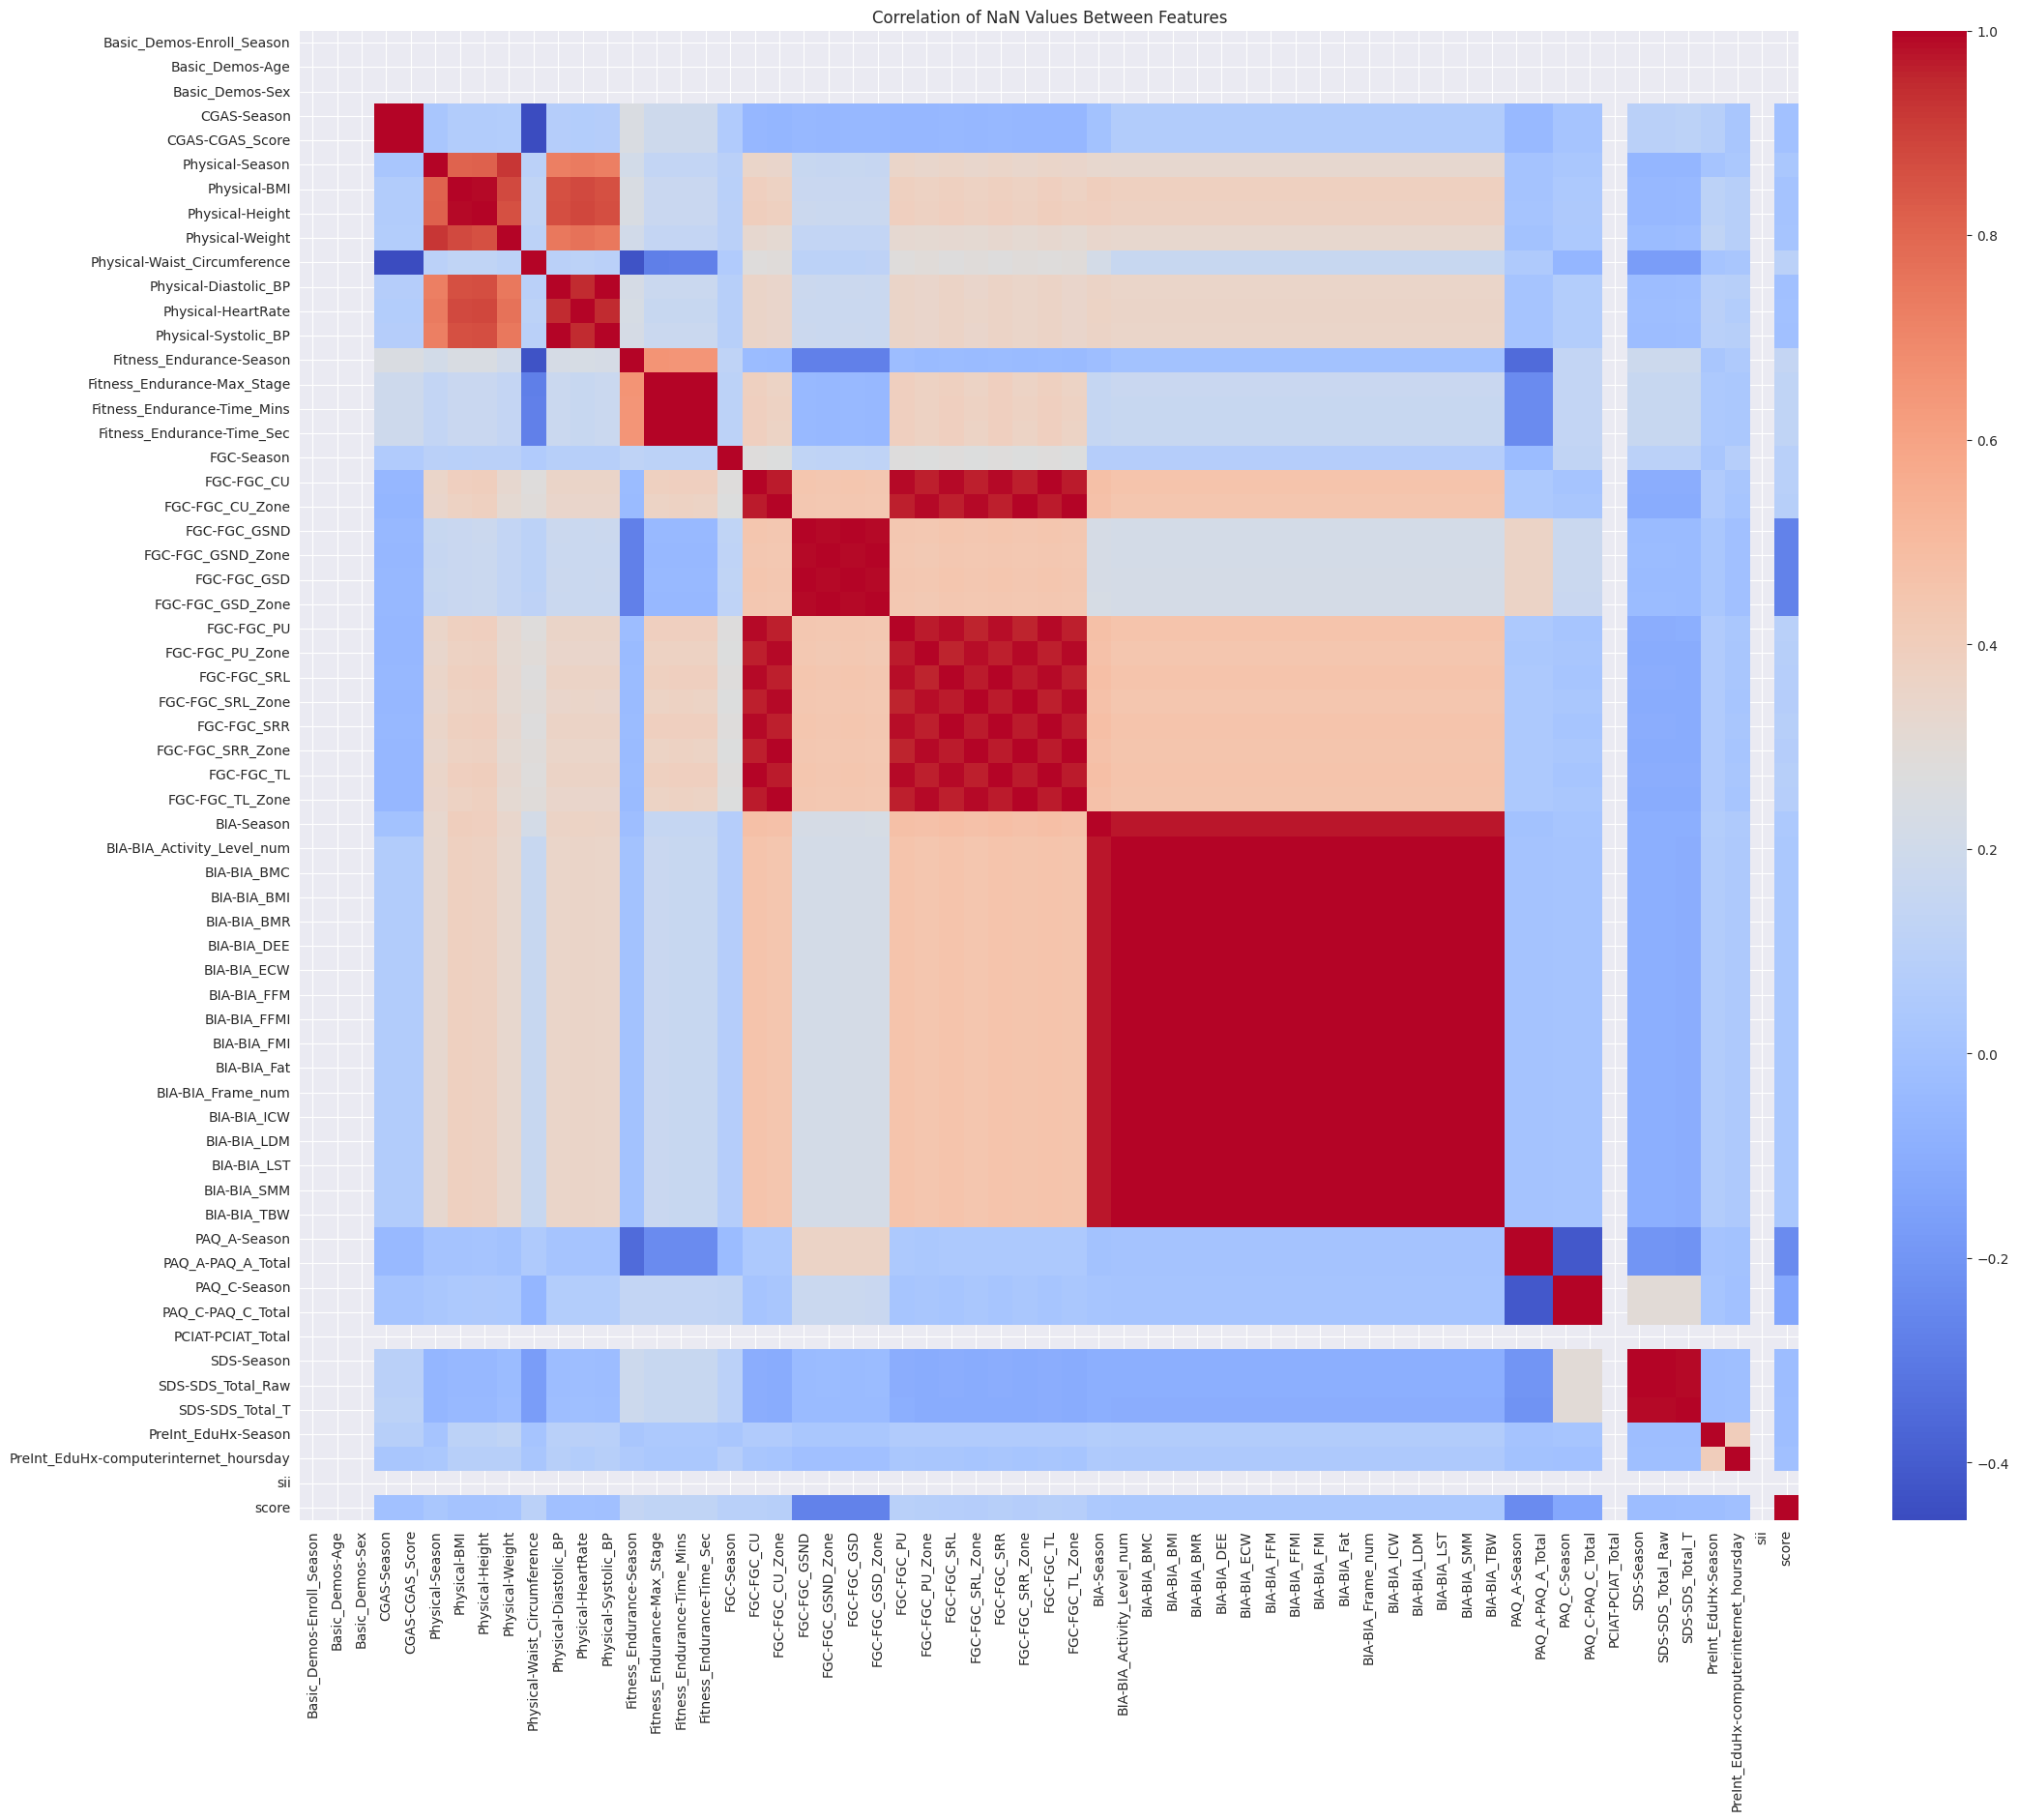

In [11]:
def nan_correlation(df):
    # Create a binary mask where NaN = 1 and non-NaN = 0
    nan_mask = df.isna().astype(int)
    nan_mask['score']=df['PCIAT-PCIAT_Total']
    # Calculate the correlation matrix for NaN occurrences
    nan_corr = nan_mask.corr()
    
    return nan_corr


train_model,train_val=stratified_split_data(train, ratio=0.8)
nan_corr=nan_correlation(train_model)
# Plot the correlation matrix using seaborn
plt.figure(figsize=(25, 20))
sns.heatmap(nan_corr, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation of NaN Values Between Features")
plt.show()


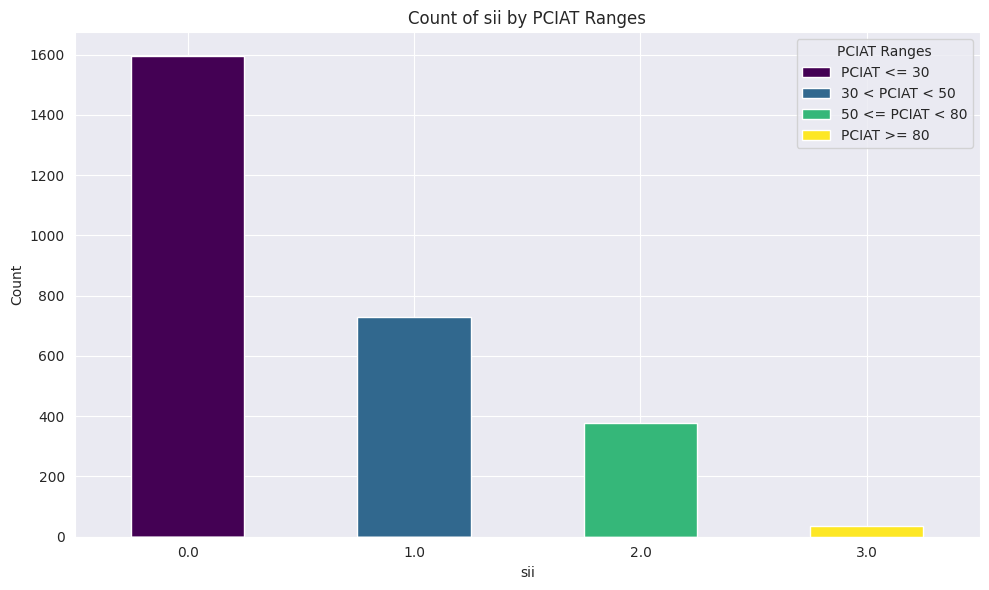

In [12]:
data = {
    'PCIAT <= 30': train[train['PCIAT-PCIAT_Total'] <= 30].sii.value_counts(),
    '30 < PCIAT < 50': train[(train['PCIAT-PCIAT_Total'] > 30) & (train['PCIAT-PCIAT_Total'] < 50)].sii.value_counts(),
    '50 <= PCIAT < 80': train[(train['PCIAT-PCIAT_Total'] >= 50) & (train['PCIAT-PCIAT_Total'] < 80)].sii.value_counts(),
    'PCIAT >= 80': train[train['PCIAT-PCIAT_Total'] >= 80].sii.value_counts()
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data).fillna(0)  # fill missing values with 0 for categories that don't exist in certain ranges

# Plotting the bar plot
df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Count of sii by PCIAT Ranges')
plt.xlabel('sii')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Make x-axis labels horizontal
plt.legend(title='PCIAT Ranges')
plt.tight_layout()  # Adjust layout to make sure everything fits
plt.show()

# Ensemble of different categories

Because Each category missing values are highly correlated within themselves, the 1st approach is to build a esemble of multiple category NN that predict values independently and combined through weights given by training quadratic kappa

separate data by category will split the categories, keeping ids.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
categories = {
        "Basic": ["Basic_Demos"],
        "CGAS": ["CGAS"],
        "Physical": ["Physical"],
        "SDS": ["SDS"],
        "PreInt_EduHx": ["PreInt_EduHx"],
        "BIA": ["BIA"],
        "Fitness_Endurance":["Fitness_Endurance"]
        
    }

def separate_data_by_category(df):
    # Define the categories and the prefixes corresponding to each category
    

    # Create empty dictionaries to store data for each category
    separated_data = {category: pd.DataFrame() for category in categories}

    # Iterate over each column and categorize them based on the prefix
    for column in df.columns:
        for category, prefixes in categories.items():
            if any(column.startswith(prefix) for prefix in prefixes):
                separated_data[category][column] = df[column]
    
    for category in separated_data:
            separated_data[category].dropna(inplace=True)
    return separated_data






# Define a custom dataset class that handles sample IDs from the index
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)
        self.sample_ids = data.index  # Use the index as sample IDs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], self.sample_ids[idx]

# Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),  
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),  
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x)*100
# Function to train multiple NNs, one per category
def train_multiple_nns(separated_data, target_df, num_epochs=300, batch_size=32, lr=0.001):
    models = {}
    optimizers = {}
    losses = {}

    # Loss function (assuming regression task, modify for classification)
    criterion = nn.MSELoss()

    # Store predictions and sample IDs for mapping later
    all_predictions = {}

    for category, data in separated_data.items():
        print(category)
        # Extract targets matching the sample IDs in separated_data
        matching_targets = target_df.loc[data.index]  # Ensure target_df index aligns with data.index
        
        # Create dataset and data loader
        dataset = CustomDataset(data, matching_targets)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize model, optimizer, and store them
        input_size = data.shape[1]
        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, target, ids in dataloader:
                optimizer.zero_grad()
                output = model(inputs).squeeze()
                loss = criterion(output, target) # scale target back to 0-1 
                loss.backward()
                optimizer.step()
        
        print(loss)
        # Inference for this category (store sample IDs and predictions)
        model.eval()
        predictions = []
        ids_collected = []
        with torch.no_grad(): 
                output = model(inputs).squeeze()
                predictions.extend(output.numpy())
                ids_collected.extend(ids)  # Keep sample IDs as strings
    
        models[category] = model
        optimizers[category] = optimizer
        # Store predictions for this category
        all_predictions[category] = pd.DataFrame({'Sample_ID': ids_collected, 'Prediction': predictions})
        
    return all_predictions,models

train model is separated and feed into categories of nns. 

In [5]:
separated_data=separate_data_by_category(train_model)
targets = train_model["PCIAT-PCIAT_Total"]
predictions,models = train_multiple_nns(separated_data, targets)

Basic
tensor(338.8230, grad_fn=<MseLossBackward0>)
CGAS
tensor(428.0559, grad_fn=<MseLossBackward0>)
Physical
tensor(133.2641, grad_fn=<MseLossBackward0>)
SDS
tensor(181.5765, grad_fn=<MseLossBackward0>)
PreInt_EduHx
tensor(484.3015, grad_fn=<MseLossBackward0>)
BIA
tensor(156.7290, grad_fn=<MseLossBackward0>)
Fitness_Endurance
tensor(224.2949, grad_fn=<MseLossBackward0>)


From the BCE Loss above of each individual categories, you can observe that the losses are quite high and fairly inaccurate. This means that each categories alone can't effectively predict the scores. 

The high loss might reflect again when we combine the predictions

The following compute kappa score of the train_model and will be used later to combine the predictions

In [6]:

kappa_scores={category:quadratic_kappa(convert(targets[predictions[category]['Sample_ID'].values].values),convert(predictions[category]['Prediction'].values*100)) if quadratic_kappa(convert(targets[predictions[category]['Sample_ID'].values].values),convert(predictions[category]['Prediction'].values))>0 else 0  for category in categories}

kappa_scores

{'Basic': 0.0,
 'CGAS': 0,
 'Physical': 0.0,
 'SDS': 0.0,
 'PreInt_EduHx': 0.0,
 'BIA': 0.0,
 'Fitness_Endurance': 0}

In [7]:
kappa_scores_normalize={key: value / sum(kappa_scores.values()) for key, value in kappa_scores.items()}
kappa_scores_normalize

/tmp/ipykernel_142/1345052959.py:1: RuntimeWarning: invalid value encountered in scalar divide
  kappa_scores_normalize={key: value / sum(kappa_scores.values()) for key, value in kappa_scores.items()}


{'Basic': nan,
 'CGAS': nan,
 'Physical': nan,
 'SDS': nan,
 'PreInt_EduHx': nan,
 'BIA': nan,
 'Fitness_Endurance': nan}

In [8]:
def make_predictions_for_test_data(test_data, models):
    all_predictions={}
    for category, model in models.items():
        if category in test_data:  # Only make predictions for categories with test data
            print(category)
            
            test_inputs = torch.tensor(test_data[category].values, dtype=torch.float32)
            with torch.no_grad():
                output = model(test_inputs).squeeze()
                
                all_predictions[category] =pd.DataFrame({'Sample_ID': test_data[category].index, 'Prediction': output.numpy()})
    
    return all_predictions

# Function to combine the predictions as done during training
def combine_test_predictions(predictions,test):
    combined_predictions = []
    
    for sample_idx in test.index:  # Loop through each sample
        available_preds = []
        available_weights = []

        for category, preds in predictions.items():
            if not preds[preds['Sample_ID']==sample_idx].empty:  # If the prediction exists (not NaN)
                available_preds.append(preds[preds['Sample_ID']==sample_idx]['Prediction'] * kappa_scores_normalize[category])
                
                available_weights.append(kappa_scores_normalize[category])

        if available_weights:  # Compute weighted average if there are available predictions
            combined_predictions.append(np.sum(available_preds) / np.sum(available_weights))
            
        else:
            combined_predictions.append(np.nan)  # No predictions available for this sample
    result=pd.DataFrame({'Sample_ID': test.index, 'Prediction':convert(combined_predictions)})
    result.set_index('Sample_ID', inplace=True)
    return result




The performance on train_model

In [9]:
separated_data=separate_data_by_category(train_model)

# Make predictions on test data for each category
test_predictions = make_predictions_for_test_data(separated_data, models)

# Combine the test predictions (same method as used during training)
final_test_predictions = combine_test_predictions(test_predictions,train_model)

targets = train_model["PCIAT-PCIAT_Total"]
kappa_scores=quadratic_kappa(convert(targets[list(final_test_predictions.index.values)].values),convert(final_test_predictions['Prediction'].values))
kappa_scores

Basic
CGAS
Physical
SDS
PreInt_EduHx
BIA
Fitness_Endurance


0.0

The performance on Valdiation:

In [10]:
separated_data=separate_data_by_category(train_val)

# Make predictions on test data for each category
test_predictions = make_predictions_for_test_data(separated_data, models)

# Combine the test predictions (same method as used during training)
final_test_predictions = combine_test_predictions(test_predictions,train_val)

targets = train_val["PCIAT-PCIAT_Total"]
kappa_scores=quadratic_kappa(convert(targets[list(final_test_predictions.index.values)].values),convert(final_test_predictions['Prediction'].values))
kappa_scores

Basic
CGAS
Physical
SDS
PreInt_EduHx
BIA
Fitness_Endurance


0.0

Both concludes that the prediction is close to random, and ensemble category technique is not good enough for complex dataset like this one

Simple NN with Mask

Simply apply the mask to remove the effect of missing values inside of the model


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class that handles sample IDs from the index
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.data = torch.nan_to_num(self.data, nan=0.0)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)
        self.sample_ids = data.index  # Use the index as sample IDs
        self.mask=np.array(data.isna().astype(int))
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], self.sample_ids[idx],self.mask[idx]

# Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),  
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),  
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x) *100
# Function to train multiple NNs, one per category
def train_mask_nns(data, target_df, num_epochs=100, batch_size=128, lr=0.0001):

    optimizers = {}
    losses = {}

    # Loss function (assuming regression task, modify for classification)
    criterion = nn.MSELoss()

    # Store predictions and sample IDs for mapping later
    all_predictions = {}
    # Extract targets matching the sample IDs in separated_data
    matching_targets = target_df.loc[data.index]  # Ensure target_df index aligns with data.index
    
    # Create dataset and data loader
    dataset = CustomDataset(data, matching_targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and store them
    input_size = data.shape[1]
    model = SimpleNN(input_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
        

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, target, ids,mask in dataloader:
            optimizer.zero_grad()
            output = model(inputs).squeeze()
            loss = criterion(output, target)
            
            loss= loss * (1-mask).float().mean(dim=1)  # Mask out NaN positions
            loss=loss.mean()
            loss.backward()
            optimizer.step()
        if epoch % 50==0:
            print(loss)
    model.eval()
    predictions = []
    ids_collected = []
    with torch.no_grad(): 
            output = model(inputs).squeeze()
            predictions.extend(output.numpy())
            ids_collected.extend(ids)  # Keep sample IDs as string
    # Store predictions for this category
    all_predictions = pd.DataFrame({'Sample_ID': ids_collected, 'Prediction': predictions})

    return all_predictions,model

Loss for mask is a lot better, meaning the dataset is more complex and interdependent

In [14]:
def make_predictions_for_test_data(test_data, model):
    model.eval()
    test_inputs = torch.tensor(test_data.values, dtype=torch.float32)
    test_inputs = torch.nan_to_num(test_inputs, nan=0.0)
    with torch.no_grad():
        output = model(test_inputs).squeeze()
    all_predictions = pd.DataFrame({'Sample_ID':  test_data.index, 'Prediction': convert(output)})

    return all_predictions

  0%|          | 0/4 [00:00<?, ?it/s]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(397.5054, grad_fn=<MeanBackward0>)
tensor(218.9067, grad_fn=<MeanBackward0>)
tensor(80.0626, grad_fn=<MeanBackward0>)
tensor(265.2137, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(848.1414, grad_fn=<MeanBackward0>)
tensor(167.6899, grad_fn=<MeanBackward0>)
tensor(53.4047, grad_fn=<MeanBackward0>)
tensor(135.6537, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(991.7798, grad_fn=<MeanBackward0>)
tensor(276.5202, grad_fn=<MeanBackward0>)
tensor(160.7275, grad_fn=<MeanBackward0>)
tensor(158.8469, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 1

 25%|██▌       | 1/4 [02:18<06:54, 138.17s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(111.2701, grad_fn=<MeanBackward0>)
tensor(263.0262, grad_fn=<MeanBackward0>)
tensor(173.3143, grad_fn=<MeanBackward0>)
tensor(72.0317, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(266.4192, grad_fn=<MeanBackward0>)
tensor(246.5065, grad_fn=<MeanBackward0>)
tensor(152.6858, grad_fn=<MeanBackward0>)
tensor(80.6632, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(239.2473, grad_fn=<MeanBackward0>)
tensor(164.5026, grad_fn=<MeanBackward0>)
tensor(35.9385, grad_fn=<MeanBackward0>)
tensor(111.3470, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 14

 50%|█████     | 2/4 [04:30<04:30, 135.01s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(425.9901, grad_fn=<MeanBackward0>)
tensor(129.4349, grad_fn=<MeanBackward0>)
tensor(85.6042, grad_fn=<MeanBackward0>)
tensor(157.7196, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(185.3472, grad_fn=<MeanBackward0>)
tensor(124.2949, grad_fn=<MeanBackward0>)
tensor(237.6185, grad_fn=<MeanBackward0>)
tensor(107.7086, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(200.2493, grad_fn=<MeanBackward0>)
tensor(83.7171, grad_fn=<MeanBackward0>)
tensor(236.1584, grad_fn=<MeanBackward0>)
tensor(85.2547, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 14

 75%|███████▌  | 3/4 [06:38<02:11, 131.54s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(134.5667, grad_fn=<MeanBackward0>)
tensor(129.6491, grad_fn=<MeanBackward0>)
tensor(189.4565, grad_fn=<MeanBackward0>)
tensor(89.6548, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(244.4609, grad_fn=<MeanBackward0>)
tensor(183.7518, grad_fn=<MeanBackward0>)
tensor(145.4981, grad_fn=<MeanBackward0>)
tensor(232.0933, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(246.7719, grad_fn=<MeanBackward0>)
tensor(344.8358, grad_fn=<MeanBackward0>)
tensor(81.6800, grad_fn=<MeanBackward0>)
tensor(116.6588, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 1

100%|██████████| 4/4 [08:43<00:00, 130.90s/it]


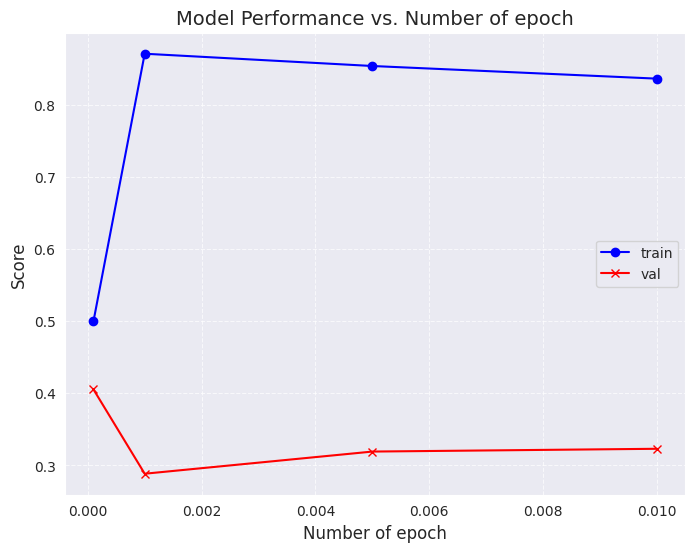

In [18]:
kappa_scores_train=[]
kappa_scores_val=[]
test_list=[0.0001,0.001,0.005,0.01]
for i in tqdm(test_list):
    train_score=0
    val_score=0
    for repeat in range(6):# repeat 6  times
        train_model,train_val=stratified_split_data(train,ratio=0.8)
        targets = train_model["PCIAT-PCIAT_Total"]
        train_model_mask_nn = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        predictions,model = train_mask_nns(train_model_mask_nn, targets,num_epochs=200,lr=i)
        kappa_scores=quadratic_kappa(convert(targets[predictions['Sample_ID'].values].values),convert(predictions['Prediction'].values))
        train_score+=kappa_scores
        targets = train_val["PCIAT-PCIAT_Total"]
        train_val_mask_nn = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        output = make_predictions_for_test_data(train_val_mask_nn, model)
        kappa_scores=quadratic_kappa(convert(targets[output['Sample_ID'].values].values),output['Prediction'].values)
        val_score+=kappa_scores
    kappa_scores_train.append(train_score/6)
    kappa_scores_val.append(val_score/6)

plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('Number of epoch', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Number of epoch', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

  0%|          | 0/3 [00:00<?, ?it/s]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(532.2584, grad_fn=<MeanBackward0>)
tensor(102.8207, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(554.3853, grad_fn=<MeanBackward0>)
tensor(302.9754, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(529.5457, grad_fn=<MeanBackward0>)
tensor(115.0813, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(428.6684, grad_fn=<MeanBackward0>)
tensor(389.9704, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7

 33%|███▎      | 1/3 [01:07<02:14, 67.15s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(486.7382, grad_fn=<MeanBackward0>)
tensor(428.4056, grad_fn=<MeanBackward0>)
tensor(139.1646, grad_fn=<MeanBackward0>)
tensor(119.4721, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(494.4500, grad_fn=<MeanBackward0>)
tensor(382.8461, grad_fn=<MeanBackward0>)
tensor(207.3175, grad_fn=<MeanBackward0>)
tensor(142.6176, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(243.8904, grad_fn=<MeanBackward0>)
tensor(266.2893, grad_fn=<MeanBackward0>)
tensor(216.9061, grad_fn=<MeanBackward0>)
tensor(204.0658, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val:

 67%|██████▋   | 2/3 [03:18<01:45, 105.20s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(495.2964, grad_fn=<MeanBackward0>)
tensor(167.1733, grad_fn=<MeanBackward0>)
tensor(95.3711, grad_fn=<MeanBackward0>)
tensor(134.8998, grad_fn=<MeanBackward0>)
tensor(286.8433, grad_fn=<MeanBackward0>)
tensor(116.1124, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(783.2249, grad_fn=<MeanBackward0>)
tensor(223.3257, grad_fn=<MeanBackward0>)
tensor(193.1344, grad_fn=<MeanBackward0>)
tensor(133.8973, grad_fn=<MeanBackward0>)
tensor(287.6873, grad_fn=<MeanBackward0>)
tensor(150.5191, grad_fn=<MeanBackward0>)
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
tensor(558.5916, grad_fn=<MeanBackward0>)
tensor(369.6555, grad_fn=<MeanBackward0>)
tensor(149.649

100%|██████████| 3/3 [06:31<00:00, 130.38s/it]


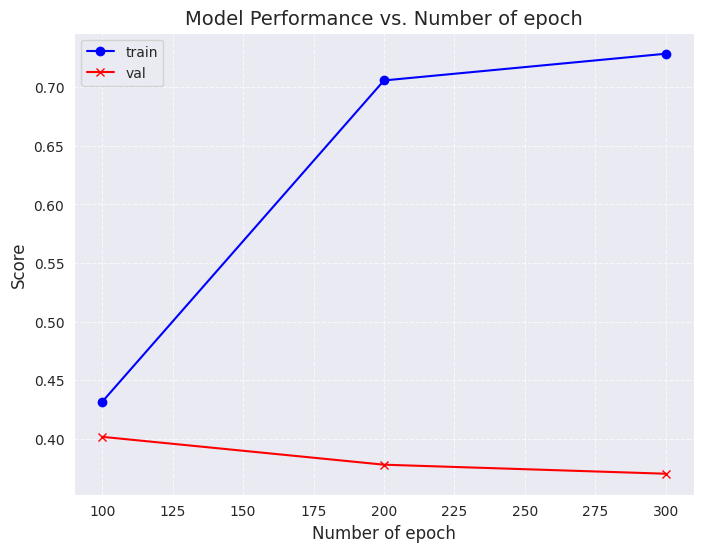

In [20]:
kappa_scores_train=[]
kappa_scores_val=[]
test_list=[100,200,300]
for i in tqdm(test_list):
    train_score=0
    val_score=0
    for repeat in range(6):# repeat 6  times
        train_model,train_val=stratified_split_data(train,ratio=0.8)
        targets = train_model["PCIAT-PCIAT_Total"]
        train_model_mask_nn = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        predictions,model = train_mask_nns(train_model_mask_nn, targets,lr=0.0001,num_epochs=i)
        kappa_scores=quadratic_kappa(convert(targets[predictions['Sample_ID'].values].values),convert(predictions['Prediction'].values))
        train_score+=kappa_scores
        targets = train_val["PCIAT-PCIAT_Total"]
        train_val_mask_nn = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        output = make_predictions_for_test_data(train_val_mask_nn, model)
        kappa_scores=quadratic_kappa(convert(targets[output['Sample_ID'].values].values),output['Prediction'].values)
        val_score+=kappa_scores
    kappa_scores_train.append(train_score/6)
    kappa_scores_val.append(val_score/6)

plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('Number of epoch', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Number of epoch', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

In [17]:
# Make predictions on test data for each category
test_cat = test.select_dtypes(exclude = 'number').columns

for season in test_cat:
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
test_predictions = make_predictions_for_test_data(test, model)

preds = pd.Series(test_predictions['Prediction'].values.ravel(), dtype='float32')
preds.index = test.index
preds

/tmp/ipykernel_30/3606155560.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


id
00008ff9    2.0
000fd460    0.0
00105258    1.0
00115b9f    2.0
0016bb22    0.0
001f3379    1.0
0038ba98    0.0
0068a485    0.0
0069fbed    1.0
0083e397    0.0
0087dd65    1.0
00abe655    0.0
00ae59c9    2.0
00af6387    1.0
00bd4359    1.0
00c0cd71    2.0
00d56d4b    0.0
00d9913d    0.0
00e6167c    0.0
00ebc35d    2.0
dtype: float32

In [17]:
preds.to_csv('submission.csv')

NN with XGBOOST like similar structure: 

Essentially: 
      
      1. train the first model, and run the model to compute absolut loss. 
      2. train the second model with previous loss as the input. repeate for n times. 
      3. save each individual models within the dictionary and use it for validation


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
# Define a custom dataset class that handles sample IDs from the index
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.data = torch.nan_to_num(self.data, nan=0.0)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.sample_ids = data.index  # Use the index as sample IDs
        self.mask=np.array(data.isna().astype(int))
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], self.sample_ids[idx],self.mask[idx]

# Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),  
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x)
def train_XG_mask_nns(data, target_df, num_epochs=200,num_models=5, batch_size=64, lr=0.0001):
    models={}
    losses=np.array([])
    

    # Loss function (assuming regression task, modify for classification)
    criterion = nn.MSELoss()

    # Store predictions and sample IDs for mapping later
    all_predictions = {}
    # Extract targets matching the sample IDs in separated_data
    matching_targets = target_df.loc[data.index]/100  # Ensure target_df index aligns with data.index
    
    # Create dataset and data loader
    dataset = CustomDataset(data, matching_targets.values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and store them
    for ith_model in range(num_models):
        
        input_size = data.shape[1]
        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if not losses.size== 0:
            # Create a new dataset using the previous losses as targets
            dataset = CustomDataset(data, losses)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            losses=np.array([])
    # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, target, ids,mask in dataloader:
                optimizer.zero_grad()
                output = model(inputs).squeeze()
                loss = criterion(output, target)
                loss= loss * (1-mask).float().mean(dim=1)   # Mask out NaN positions
                loss=loss.mean()
                loss.backward()
                optimizer.step()
            #if epoch % 50==0:
                #print(ith_model)
                #print('Epoch'+str(epoch))
                #print(loss)

        model.eval()
        for inputs, target, ids,mask in dataloader:
            optimizer.zero_grad()
            output = model(inputs).squeeze()
            loss = target-output
            loss= loss * (1-mask).float().mean(dim=1)  # Mask out NaN positions
            losses=np.append(losses,loss.detach().numpy())

        models[ith_model] = model
        
 

    return models

In [23]:
def run_XG_mask_nns(test_data, models,batch_size=32):
    output_list=np.array([])
    index_name=[]

    # Initialize model, optimizer, and store them
    for ith_model in range(len(models)):
        model=models[ith_model]
        model.eval()
        #print(f"\nrunning Model...")
        test_inputs = torch.tensor(test_data.values, dtype=torch.float32)
        test_inputs = torch.nan_to_num(test_inputs, nan=0.0)
    # Training loop
        with torch.no_grad():
            output = model(test_inputs).squeeze()
        if output_list.size==0:
            output_list=output
        else:
            output_list=output_list+output
    all_predictions = pd.DataFrame({'Sample_ID':  test_data.index, 'Prediction': convert(output_list*100)})
        
 

    return all_predictions
    

Optimizing over epoch

  0%|          | 0/6 [00:00<?, ?it/s]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


 17%|█▋        | 1/6 [04:48<24:03, 288.80s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


 33%|███▎      | 2/6 [11:56<24:42, 370.54s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


 50%|█████     | 3/6 [21:29<23:09, 463.09s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


 67%|██████▋   | 4/6 [33:38<18:56, 568.14s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


 83%|████████▎ | 5/6 [48:04<11:15, 675.27s/it]

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7


100%|██████████| 6/6 [1:07:00<00:00, 670.04s/it]


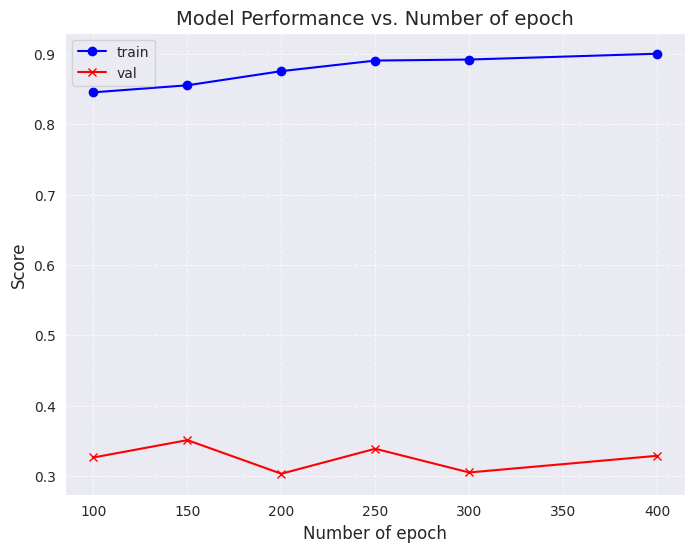

In [20]:

test_list=[100,150,200,250,300,400]
kappa_scores_train=[]
kappa_scores_val=[]
for i in tqdm(test_list):
    train_score=0
    val_score=0
    for repeat in range(6):# repeat 6  times
        train_model,train_val=stratified_split_data(train,ratio=0.8)
        targets_train = train_model["PCIAT-PCIAT_Total"]
        run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        targets_val = train_val["PCIAT-PCIAT_Total"]
        run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=3,num_epochs=i,lr=0.002)

        output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
        output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
        train_score=train_score+quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
        val_score=val_score+quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)
    kappa_scores_train.append(train_score/6)
    kappa_scores_val.append(val_score/6)

plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('Number of epoch', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Number of epoch', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
sii = 1.0 | Train: 584 | Val: 146
sii = 3.0 | Train: 27 | Val: 7
sii = 2.0 | Train: 302 | Val: 76
sii = 0.0 | Train: 1275 | Val: 319
s

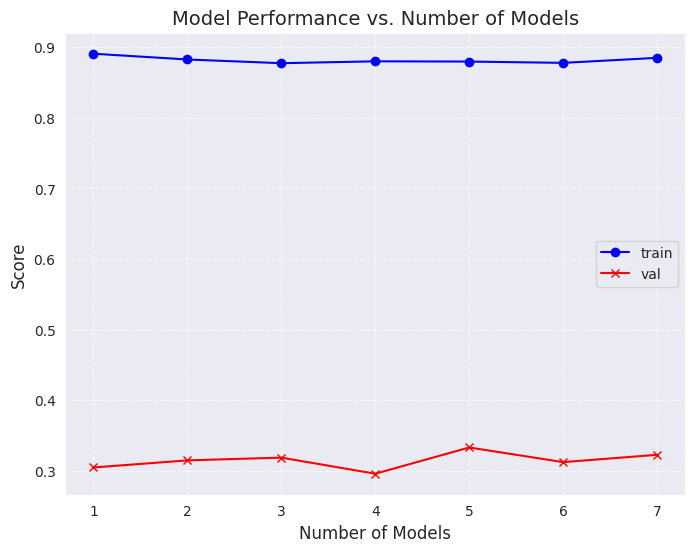

In [24]:
test_list=[1,2,3,4,5,6,7]
kappa_scores_train=[]
kappa_scores_val=[]
for i in test_list:
    train_score=0
    val_score=0
    for repeat in range(6):# repeat 3  times
        train_model,train_val=stratified_split_data(train,ratio=0.8)
        targets_train = train_model["PCIAT-PCIAT_Total"]
        run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        targets_val = train_val["PCIAT-PCIAT_Total"]
        run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=i,num_epochs=200,lr=0.0015)

        output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
        output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
        
        train_score=train_score+quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
        val_score=val_score+quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)
    kappa_scores_train.append(train_score/6)
    kappa_scores_val.append(val_score/6)

plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('Number of Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Number of Models', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

100%|██████████| 6/6 [09:59<00:00, 99.88s/it] 


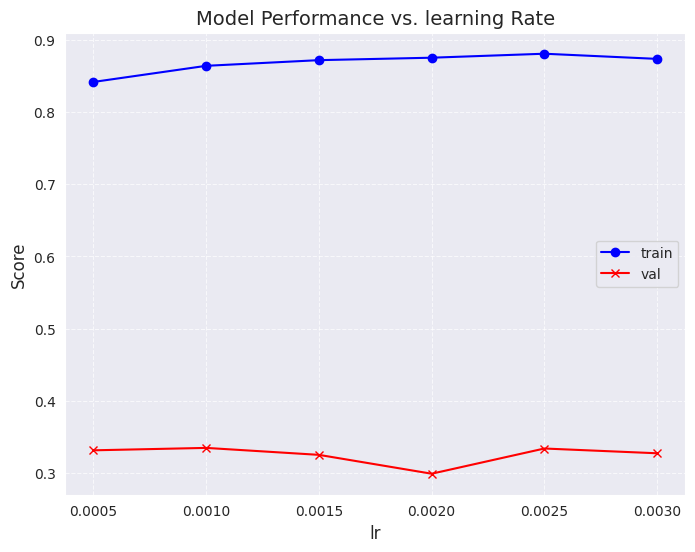

In [26]:
from tqdm import tqdm
test_list=[0.0005,0.001,0.0015,0.002,0.0025,0.0030]
kappa_scores_train=[]
kappa_scores_val=[]
for i in test_list:
    train_score=0
    val_score=0
    for repeat in tqdm(range(6)):# repeat 3  times
        targets_train = train_model["PCIAT-PCIAT_Total"]
        run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        targets_val = train_val["PCIAT-PCIAT_Total"]
        run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=3,num_epochs=200,lr=i)

        output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
        output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
        train_score=train_score+quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
        val_score=val_score+quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)
    kappa_scores_train.append(train_score/6)
    kappa_scores_val.append(val_score/6)
    
plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('lr', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. learning Rate', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

In [ ]:
test_list=[0.0005,0.00075,0.001,0.0015,0.00175,0.002]
kappa_scores_train=[]
kappa_scores_val=[]
for i in test_list:
    train_score=0
    val_score=0
    for repeat in range(3):# repeat 3  times
        targets_train = train_model["PCIAT-PCIAT_Total"]
        run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        targets_val = train_val["PCIAT-PCIAT_Total"]
        run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=3,num_epochs=200,lr=i)

        output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
        output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
        train_score=train_score+quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
        val_score=val_score+quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)
    kappa_scores_train.append(train_score/3)
    kappa_scores_val.append(val_score/3)
    
plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('lr', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. learning Rate', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

In [ ]:
test_list=[1,2,3,7]
kappa_scores_train=[]
kappa_scores_val=[]
for i in test_list:
    train_score=0
    val_score=0
    for repeat in range(3):# repeat 3  times
        targets_train = train_model["PCIAT-PCIAT_Total"]
        run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        targets_val = train_val["PCIAT-PCIAT_Total"]
        run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
        models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=i,num_epochs=200,lr=0.0025)

        output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
        output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
        
        train_score=train_score+quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
        val_score=val_score+quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)
    kappa_scores_train.append(train_score/3)
    kappa_scores_val.append(val_score/3)

plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the plot

plt.plot(test_list, kappa_scores_train, marker='o', linestyle='-', color='b', label='train')  # Line with markers
plt.plot(test_list, kappa_scores_val, marker='x', linestyle='-', color='r', label='val')  # Line with markers

# Adding labels and title
plt.xlabel('Number of Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Number of Models', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

In [ ]:
train_model,train_val=stratified_split_data(train, ratio=0.8)
targets_train = train_model["PCIAT-PCIAT_Total"]
run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
targets_val = train_val["PCIAT-PCIAT_Total"]
run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=3,num_epochs=200,lr=0.0025)

output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
train_score=quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
val_score=quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)

In [ ]:
print(train_score)
print(val_score)

In [ ]:
# Make predictions on test data for each category
test_cat = test.select_dtypes(exclude = 'number').columns

for season in test_cat:
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

test_predictions = run_XG_mask_nns(test, models)

preds = pd.Series(test_predictions['Prediction'].values.ravel(), dtype='float32')
preds.index = test.index
preds

In [ ]:
preds.to_csv('submission.csv')

In [ ]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df


In [ ]:
train_feature=feature_engineering(train)
train_model,train_val=stratified_split_data(train, ratio=0.8)
targets_train = train_model["PCIAT-PCIAT_Total"]
run_model_mask_nn_train = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
targets_val = train_val["PCIAT-PCIAT_Total"]
run_model_mask_nn_val = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
models= train_XG_mask_nns(run_model_mask_nn_train, targets_train,num_models=3,num_epochs=200,lr=0.0025)

output_train=run_XG_mask_nns(run_model_mask_nn_train,models)
output_val=run_XG_mask_nns(run_model_mask_nn_val,models)
train_score=quadratic_kappa(convert(targets_train[output_train['Sample_ID'].values].values),output_train['Prediction'].values)
val_score=quadratic_kappa(convert(targets_val[output_val['Sample_ID'].values].values),output_val['Prediction'].values)

In [ ]:
train_score

In [ ]:
val_score